## Merging data to form a complete dataset

In [6]:
import pandas as pd
pd.set_option('display.max_rows', None)

# Load proteomics CSV
proteomics = pd.read_csv("C:/Users/danjo/OneDrive - University of Plymouth/PROJ518 - Dan Jones/ADNI data/adni_proteomicsv2/adni_plasma_qc_multiplex_11Nov2010.csv")
proteomics = proteomics.rename(columns={'Visit_Code': 'VISCODE'})

# Load ADNIMERGE and just extract RID, VISCODE, and DX_bl (baseline diagnosis)
adnimerge = pd.read_csv("C:/Users/danjo/OneDrive - University of Plymouth/PROJ518 - Dan Jones/ADNI data/ADNIMERGE_23Jun2025.csv")
adni_subset = adnimerge[['RID', 'VISCODE', 'DX_bl', 'AGE', 'PTGENDER', 'APOE4']]
proteomics_labeled = pd.merge(proteomics, adni_subset, on=['RID', 'VISCODE'], how='inner')

proteomics_labeled.to_csv("C:/Users/danjo/OneDrive - University of Plymouth/PROJ518 - Dan Jones/ADNI data/ADNI (proteomics only).csv", index=False)

C:\Users\danjo\AppData\Local\Temp\ipykernel_17356\3290890752.py:9: DtypeWarning: Columns (19,20,21,50,51,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  adnimerge = pd.read_csv("C:/Users/danjo/OneDrive - University of Plymouth/PROJ518 - Dan Jones/ADNI data/ADNIMERGE_23Jun2025.csv")


## Setup

In [10]:
# !pip install xgboost tensorflow seaborn matplotlib scikit-learn joblib --quiet

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

RANDOM_STATE = 42
BINARY_CN_AD = True  # True: CN vs AD (drops MCI). False: CN/MCI/AD

DATA_PATH = r"C:/Users/danjo/OneDrive - University of Plymouth/PROJ518 - Dan Jones/ADNI data/ADNI (proteomics only).csv"


In [11]:
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.shape)
df_raw.head(3)


(1062, 199)


,ID,RID,VISCODE,RBM Sample ID,Sample_Received_Date,Alpha-1-Microglobulin (A1Micro) (ug/ml),Alpha-2-Macroglobulin (A2Macro) (mg/mL),Alpha-1-Antichymotrypsin (AACT) (ug/ml),Alpha-1-Antitrypsin (AAT) (mg/mL),Angiotensin-Converting Enzyme (ACE) (ng/ml),...,Transthyretin (TTR) (mg/dl),Vascular Cell Adhesion Molecule-1 (VCAM- (ng/mL),Vascular Endothelial Growth Factor (VEGF (pg/mL),Vitronectin (ug/ml),Vitamin K-Dependent Protein S (VKDPS) (ug/ml),von Willebrand Factor (vWF) (ug/mL),DX_bl,AGE,PTGENDER,APOE4
0,1,3,bl,KA8000CL-02,13-Sep-05,1.17609,0.07918,2.33445,0.44716,2.00432,...,2.68305,2.98722,2.97035,2.96379,1.23045,1.14613,AD,81.3,Male,1.0
1,2,3,m12,JA803SV4-02,14-Sep-06,1.23045,0.11394,2.41996,0.41497,1.99123,...,2.61700,2.96802,2.86510,2.91593,1.25527,1.82607,AD,81.3,Male,1.0
2,3,4,bl,GA800119-04,9-Nov-05,1.34242,-0.07572,2.51720,0.43136,2.25285,...,2.64542,2.84136,2.95904,3.01284,1.32222,1.89209,LMCI,67.5,Male,0.0


## Data augmentation to provide labels and keep only baseline visits (not measuring patients more than once)

In [12]:
assert 'DX_bl' in df_raw.columns, "DX_bl column is required."
df = df_raw.copy()

df = df[df['VISCODE'].str.lower() == 'bl'].copy()
dx = df['DX_bl'].astype(str).str.upper().str.strip()
map_diag = {
    'CN': 0, 'COGNITIVELY NORMAL': 0, 'NORMAL': 0, 'SMC': 0,
    'MCI': 1, 'EMCI': 1, 'LMCI': 1,
    'AD': 2, 'DEMENTIA': 2
}
df['label'] = dx.map(map_diag)

before = len(df)
df = df[df['label'].notna()].copy()
print(f"Dropped {before - len(df)} rows with unknown/missing DX_bl.")

if BINARY_CN_AD:
    df = df[df['label'] != 1].copy()
    df['label'] = df['label'].replace({2: 1})
    print("Binary CN(0) vs AD(1) counts:\n", df['label'].value_counts().sort_index())
else:
    print("Multiclass counts (0=CN,1=MCI,2=AD):\n", df['label'].value_counts().sort_index())


Dropped 0 rows with unknown/missing DX_bl.
Binary CN(0) vs AD(1) counts:
 label
0     58
1    112
Name: count, dtype: int64


## Further data augmentation

In [13]:
# Drop non-features if present
drop_cols = [c for c in ['ID','RID','VISCODE','RBM Sample ID','Sample_Received_Date','DX_bl'] if c in df.columns]
df = df.drop(columns=drop_cols, errors='ignore')

# Coerce numerics; treat placeholders as NaN
placeholders = ['.', 'NA', 'NaN', 'nan', '', 'None', 'NULL']
df = df.replace(placeholders, np.nan)
for c in df.columns:
    if c != 'label':
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop columns with >90% missing
missing_pct = df.isna().mean()
cols_hi_missing = missing_pct[missing_pct > 0.90].index.tolist()
df = df.drop(columns=cols_hi_missing, errors='ignore')
print(f"Dropped {len(cols_hi_missing)} columns with >90% missing.")

# Near-constant features
from sklearn.feature_selection import VarianceThreshold
X_tmp = df.drop(columns=['label'])
X_tmp_med = X_tmp.fillna(X_tmp.median())
vt = VarianceThreshold(threshold=1e-5)
vt.fit(X_tmp_med)
keep_mask = vt.get_support()
df = pd.concat([X_tmp.loc[:, keep_mask], df['label']], axis=1)

# Highly collinear (|rho| > 0.95)
X_tmp = df.drop(columns=['label'])
corr = X_tmp.corr(numeric_only=True).abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
df = df.drop(columns=to_drop_corr)
print(f"Dropped {len(to_drop_corr)} highly collinear columns (|rho|>0.95).")

print("Shape after cleaning:", df.shape)


Dropped 45 columns with >90% missing.
Dropped 0 highly collinear columns (|rho|>0.95).
Shape after cleaning: (170, 149)


## Split data - 119 train samples, 51 test samples, 148 features

In [14]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['label'])
y = df['label'].astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

is_binary = (y.nunique() == 2)
class_order = sorted(y.unique())
class_names = {0: "CN", 1: "AD"} if is_binary else {0: "CN", 1: "MCI", 2: "AD"}

print(X_train_raw.shape, X_test_raw.shape, "Classes:", class_order)


(119, 148) (51, 148) Classes: [np.int64(0), np.int64(1)]


## Useful functions

In [15]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

def compute_scores(y_true, y_proba):
    y_true = np.asarray(y_true)
    if is_binary:
        y_pred = (y_proba >= 0.5).astype(int)
        auroc = roc_auc_score(y_true, y_proba)
        auprc = average_precision_score(y_true, y_proba)
    else:
        y_pred = np.argmax(y_proba, axis=1)
        Yb = label_binarize(y_true, classes=class_order)
        auroc = roc_auc_score(Yb, y_proba, average='macro', multi_class='ovr')
        auprc = np.mean([average_precision_score(Yb[:,k], y_proba[:,k]) for k in range(len(class_order))])
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    return {"acc": acc, "f1_macro": f1m, "auroc": auroc, "auprc": auprc, "y_pred": y_pred}

def show_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    labels = class_order
    tick = [class_names[i] for i in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(4.6, 4.0))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=tick, yticklabels=tick)
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

def plot_roc_pr(y_true, y_proba, name="Model"):
    if is_binary:
        RocCurveDisplay.from_predictions(y_true, y_proba)
        plt.title(f"{name} — ROC"); plt.tight_layout(); plt.show()
        PrecisionRecallDisplay.from_predictions(y_true, y_proba)
        plt.title(f"{name} — Precision-Recall"); plt.tight_layout(); plt.show()
    else:
        Yb = label_binarize(y_true, classes=class_order)
        for k in range(len(class_order)):
            RocCurveDisplay.from_predictions(Yb[:,k], y_proba[:,k])
            plt.title(f"{name} — ROC ({class_names[class_order[k]]})")
            plt.tight_layout(); plt.show()
            PrecisionRecallDisplay.from_predictions(Yb[:,k], y_proba[:,k])
            plt.title(f"{name} — PR ({class_names[class_order[k]]})")
            plt.tight_layout(); plt.show()

def report(y_true, y_pred, name="Model"):
    target_names = [class_names[i] for i in class_order]
    print(f"\n{name} — classification report")
    print(classification_report(y_true, y_pred, labels=class_order, target_names=target_names, digits=3))


## Defining SVM and XGBoost models

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

# XGB imbalance heuristic (binary)
scale_pos_weight = 1.0
if is_binary:
    pos = (y_train == 1).sum()
    neg = (y_train == 0).sum()
    scale_pos_weight = (neg / pos) if pos > 0 else 1.0

# SVM: needs scaling + probability=True for ROC/PR; class_weight to handle imbalance
svm_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("clf", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True,
        class_weight="balanced",     # handle imbalance
        random_state=RANDOM_STATE,
    ))
])

# XGBoost
xgb_params = dict(
    n_estimators=700, max_depth=4, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
    random_state=RANDOM_STATE, n_jobs=-1
)
if is_binary:
    xgb_params.update(dict(objective='binary:logistic', eval_metric='logloss',
                           scale_pos_weight=scale_pos_weight))
else:
    xgb_params.update(dict(objective='multi:softprob', eval_metric='mlogloss',
                           num_class=len(class_order)))

xgb_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("clf", XGBClassifier(**xgb_params))
])


## Training and testing SVM and XGBoost models


SVM (RBF) — Acc: 0.882  F1(macro): 0.863  AUROC: 0.926  AUPRC: 0.958

SVM (RBF) — classification report
              precision    recall  f1-score   support

          CN      0.867     0.765     0.812        17
          AD      0.889     0.941     0.914        34

    accuracy                          0.882        51
   macro avg      0.878     0.853     0.863        51
weighted avg      0.881     0.882     0.880        51



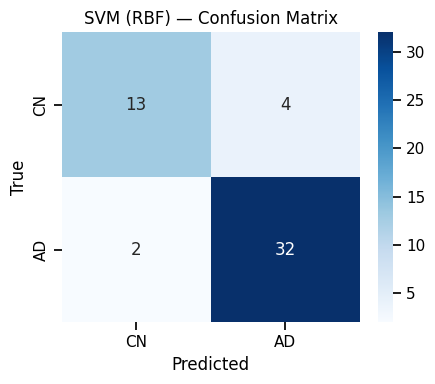

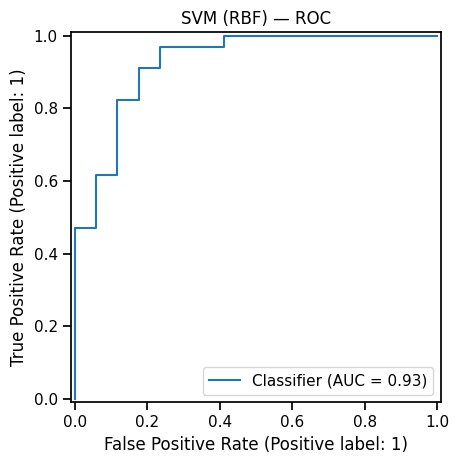

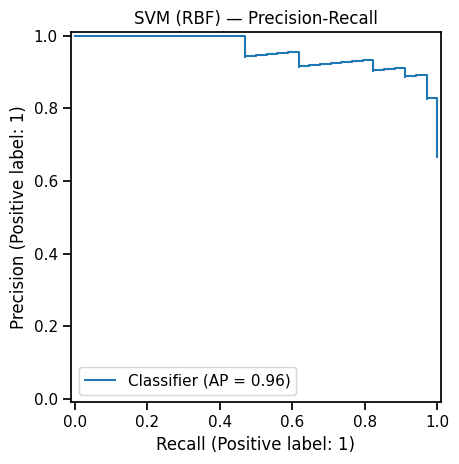


XGBoost — Acc: 0.882  F1(macro): 0.868  AUROC: 0.920  AUPRC: 0.959

XGBoost — classification report
              precision    recall  f1-score   support

          CN      0.824     0.824     0.824        17
          AD      0.912     0.912     0.912        34

    accuracy                          0.882        51
   macro avg      0.868     0.868     0.868        51
weighted avg      0.882     0.882     0.882        51



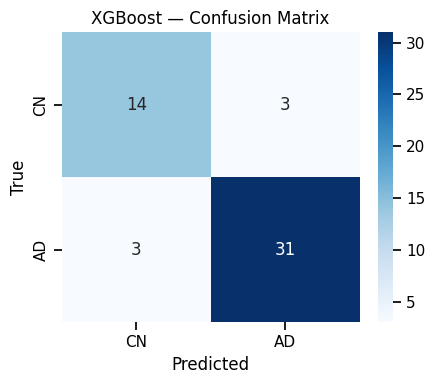

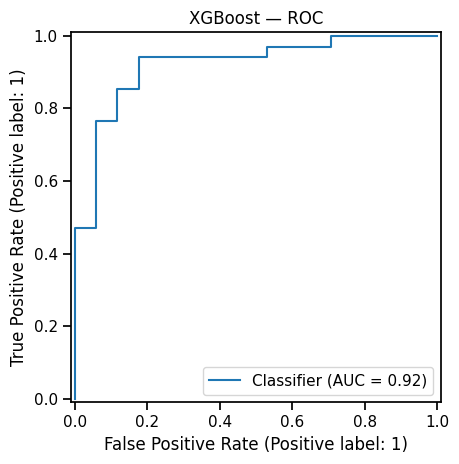

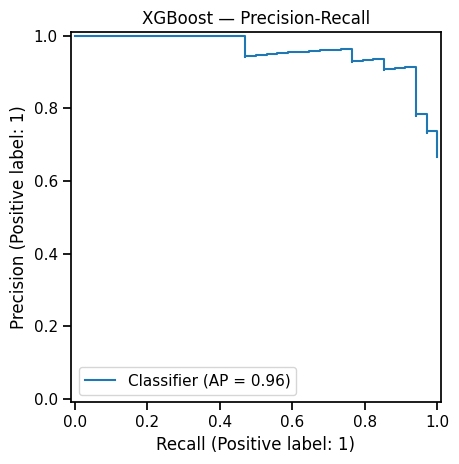

,acc,f1_macro,auroc,auprc,y_pred
SVM (RBF),0.882353,0.863393,0.925606,0.957779,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
XGBoost,0.882353,0.867647,0.920415,0.959057,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."


In [17]:
results = {}

for name, pipe in [("SVM (RBF)", svm_pipe),
                   ("XGBoost",  xgb_pipe)]:
    pipe.fit(X_train_raw, y_train)
    proba = pipe.predict_proba(X_test_raw)
    y_proba = proba[:,1] if is_binary else proba
    scores = compute_scores(y_test, y_proba)
    results[name] = scores
    print(f"\n{name} — Acc: {scores['acc']:.3f}  F1(macro): {scores['f1_macro']:.3f}  "
          f"AUROC: {scores['auroc']:.3f}  AUPRC: {scores['auprc']:.3f}")
    report(y_test, scores["y_pred"], name=name)
    show_confusion_matrix(y_test, scores["y_pred"], title=f"{name} — Confusion Matrix")
    plot_roc_pr(y_test, y_proba, name=name)

pd.DataFrame(results).T


## Analyse feature importance

Top features — SVM (RBF)


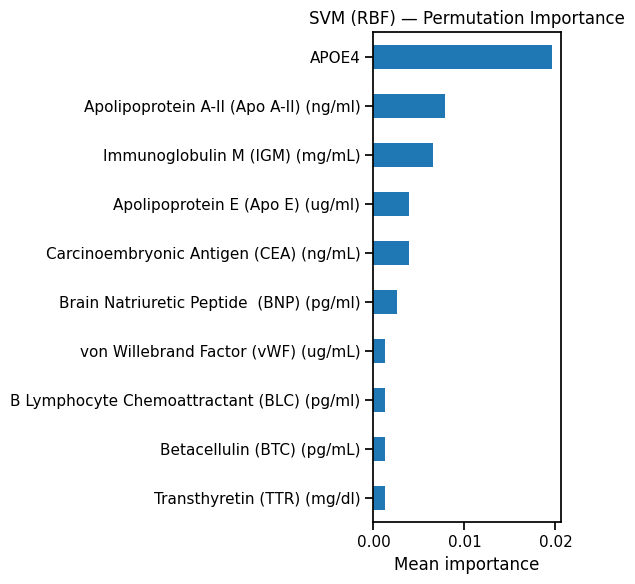

Top features — XGBoost


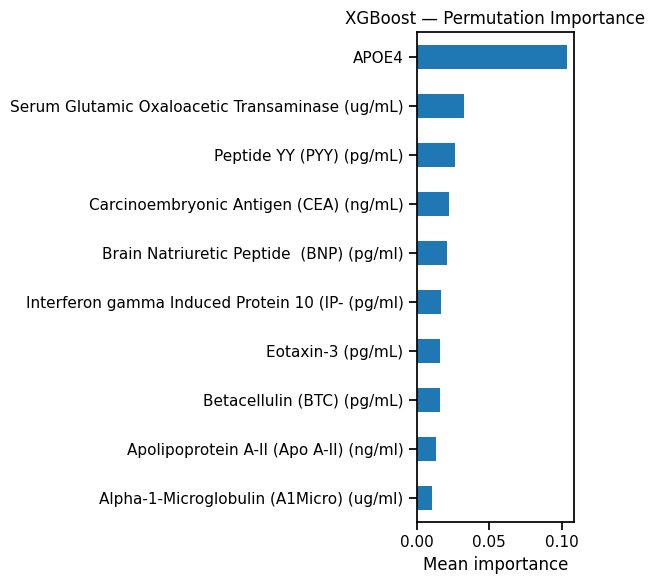

In [18]:
from sklearn.inspection import permutation_importance

def top_perm_importance(pipe, X_val, y_val, n_repeats=15, top_k=10, name="Model"):
    r = permutation_importance(pipe, X_val, y_val, n_repeats=n_repeats,
                               random_state=RANDOM_STATE, scoring=None)
    importances = pd.Series(r.importances_mean, index=X.columns)
    top = importances.sort_values(ascending=False).head(top_k)
    ax = top[::-1].plot(kind="barh", figsize=(6, 6))
    ax.set_title(f"{name} — Permutation Importance")
    ax.set_xlabel("Mean importance")
    plt.tight_layout(); plt.show()
    return top

print("Top features — SVM (RBF)")
top_svm = top_perm_importance(svm_pipe, X_test_raw, y_test, name="SVM (RBF)")

print("Top features — XGBoost")
top_xgb = top_perm_importance(xgb_pipe, X_test_raw, y_test, name="XGBoost")



=== Retraining with Top-4 Features ===
SVM (RBF) — Acc: 0.784  F1(macro): 0.772  AUROC: 0.870  AUPRC: 0.945

SVM (RBF) (top-4) — classification report
              precision    recall  f1-score   support

          CN      0.636     0.824     0.718        17
          AD      0.897     0.765     0.825        34

    accuracy                          0.784        51
   macro avg      0.766     0.794     0.772        51
weighted avg      0.810     0.784     0.790        51



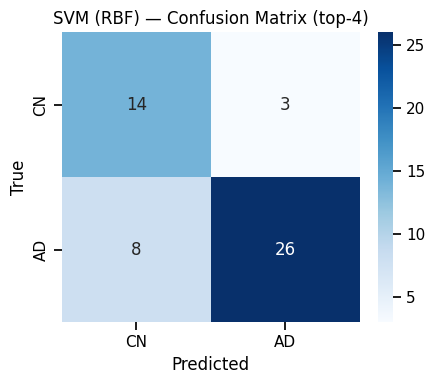

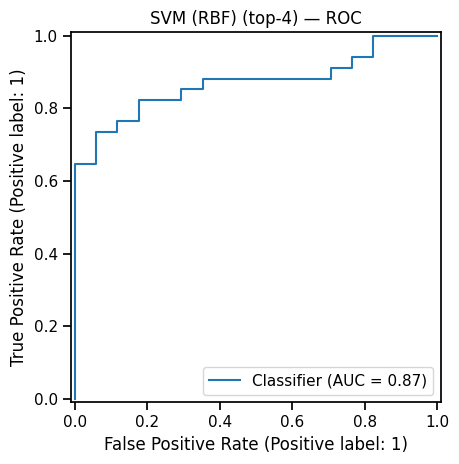

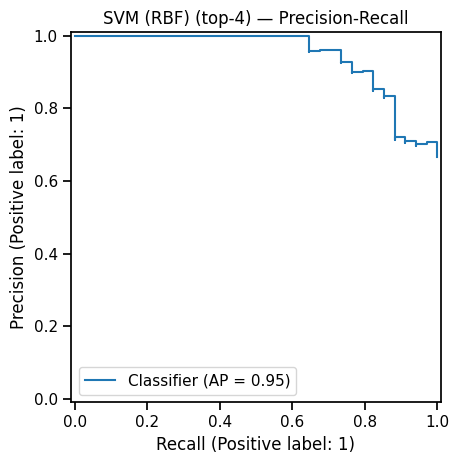

XGBoost — Acc: 0.843  F1(macro): 0.828  AUROC: 0.875  AUPRC: 0.931

XGBoost (top-4) — classification report
              precision    recall  f1-score   support

          CN      0.737     0.824     0.778        17
          AD      0.906     0.853     0.879        34

    accuracy                          0.843        51
   macro avg      0.822     0.838     0.828        51
weighted avg      0.850     0.843     0.845        51



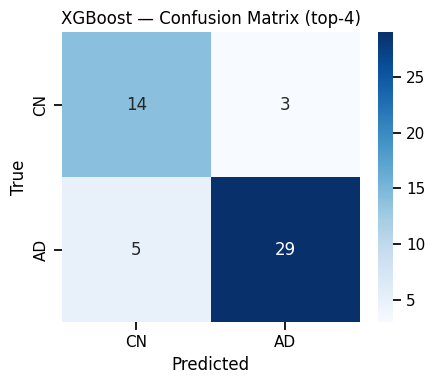

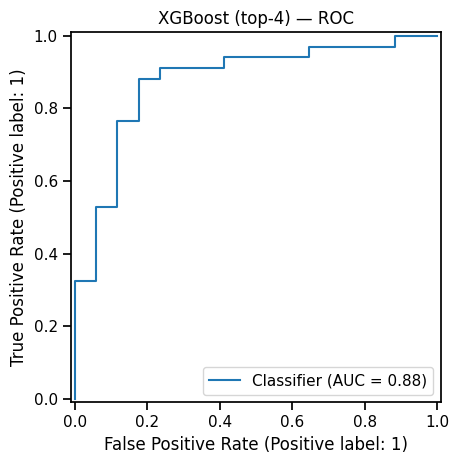

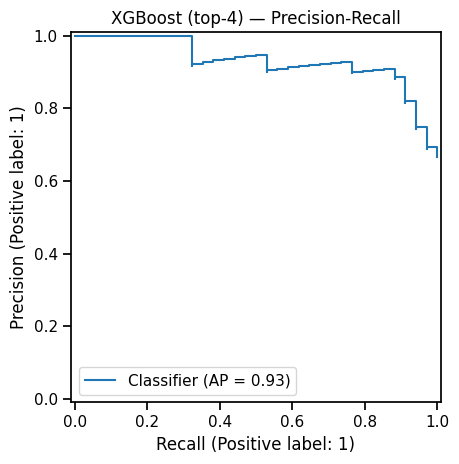


=== Retraining with Top-6 Features ===
SVM (RBF) — Acc: 0.902  F1(macro): 0.888  AUROC: 0.924  AUPRC: 0.966

SVM (RBF) (top-6) — classification report
              precision    recall  f1-score   support

          CN      0.875     0.824     0.848        17
          AD      0.914     0.941     0.928        34

    accuracy                          0.902        51
   macro avg      0.895     0.882     0.888        51
weighted avg      0.901     0.902     0.901        51



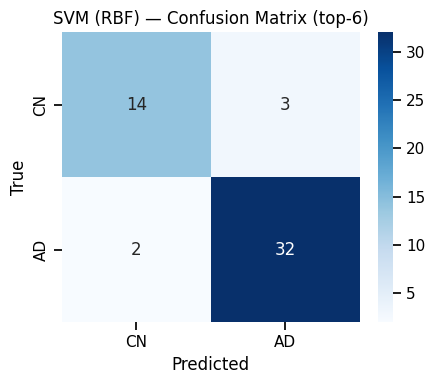

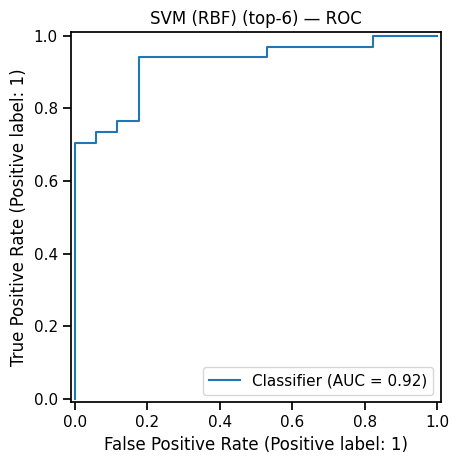

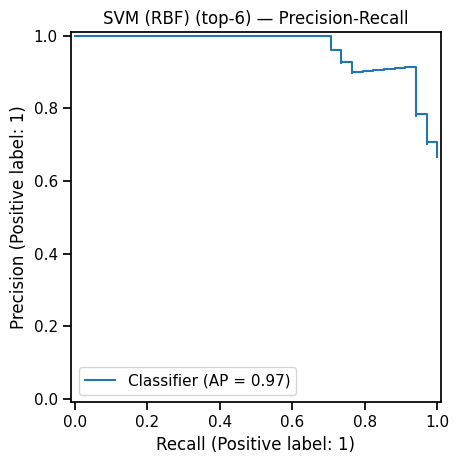

XGBoost — Acc: 0.843  F1(macro): 0.828  AUROC: 0.898  AUPRC: 0.948

XGBoost (top-6) — classification report
              precision    recall  f1-score   support

          CN      0.737     0.824     0.778        17
          AD      0.906     0.853     0.879        34

    accuracy                          0.843        51
   macro avg      0.822     0.838     0.828        51
weighted avg      0.850     0.843     0.845        51



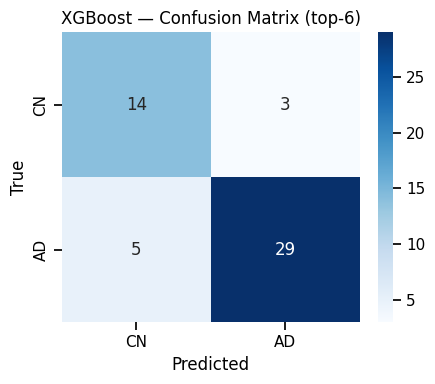

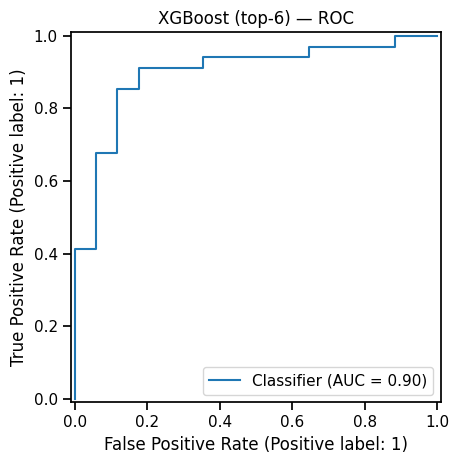

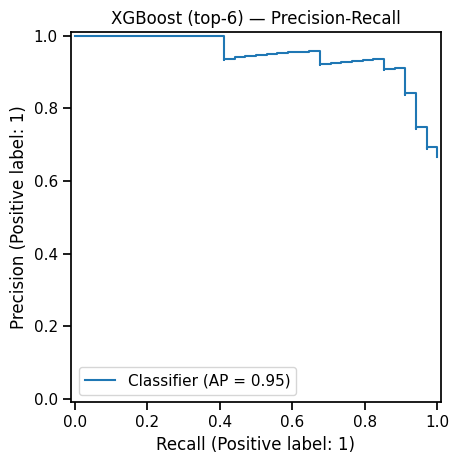


=== Retraining with Top-8 Features ===
SVM (RBF) — Acc: 0.863  F1(macro): 0.838  AUROC: 0.896  AUPRC: 0.952

SVM (RBF) (top-8) — classification report
              precision    recall  f1-score   support

          CN      0.857     0.706     0.774        17
          AD      0.865     0.941     0.901        34

    accuracy                          0.863        51
   macro avg      0.861     0.824     0.838        51
weighted avg      0.862     0.863     0.859        51



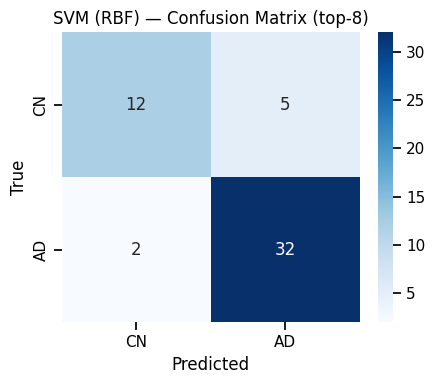

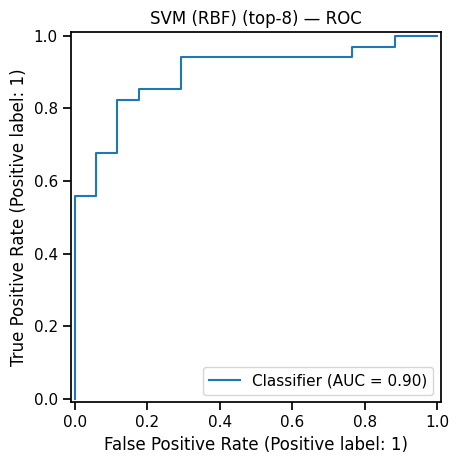

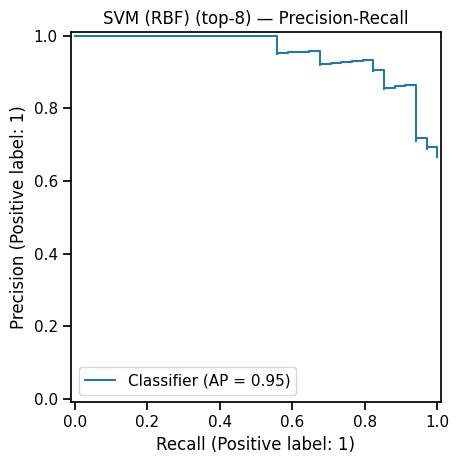

XGBoost — Acc: 0.882  F1(macro): 0.871  AUROC: 0.920  AUPRC: 0.952

XGBoost (top-8) — classification report
              precision    recall  f1-score   support

          CN      0.789     0.882     0.833        17
          AD      0.938     0.882     0.909        34

    accuracy                          0.882        51
   macro avg      0.863     0.882     0.871        51
weighted avg      0.888     0.882     0.884        51



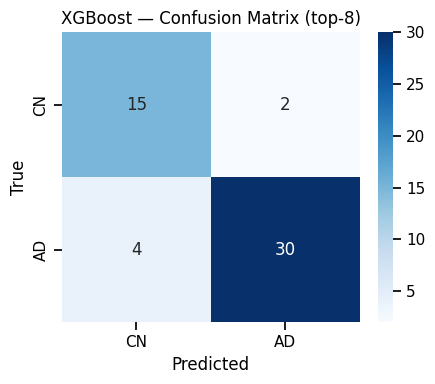

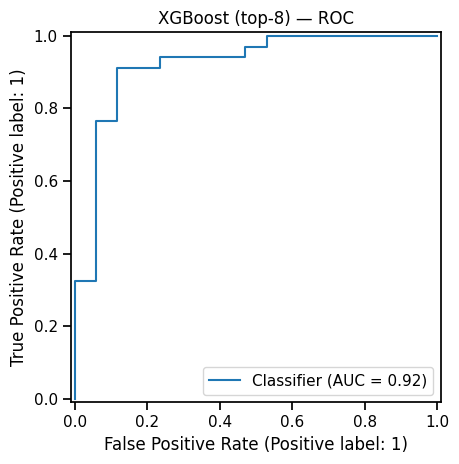

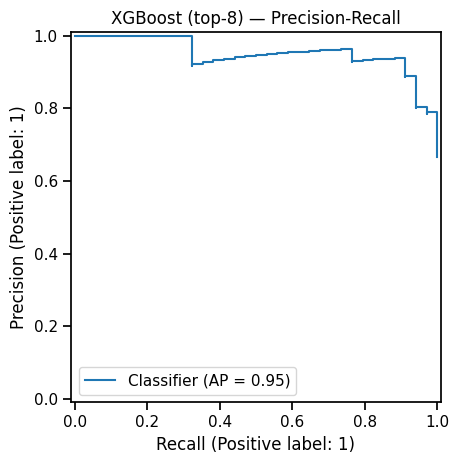


=== Retraining with Top-10 Features ===
SVM (RBF) — Acc: 0.824  F1(macro): 0.791  AUROC: 0.894  AUPRC: 0.954

SVM (RBF) (top-10) — classification report
              precision    recall  f1-score   support

          CN      0.786     0.647     0.710        17
          AD      0.838     0.912     0.873        34

    accuracy                          0.824        51
   macro avg      0.812     0.779     0.791        51
weighted avg      0.820     0.824     0.819        51



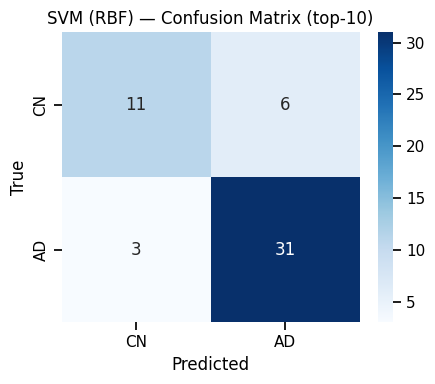

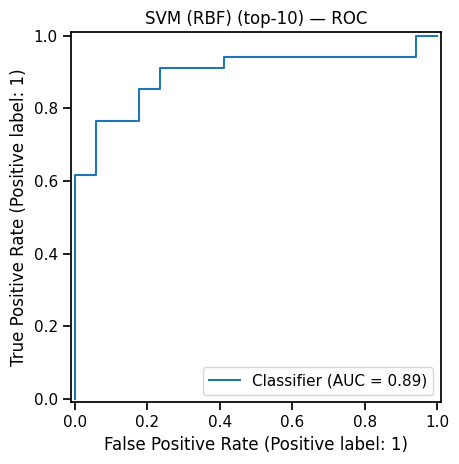

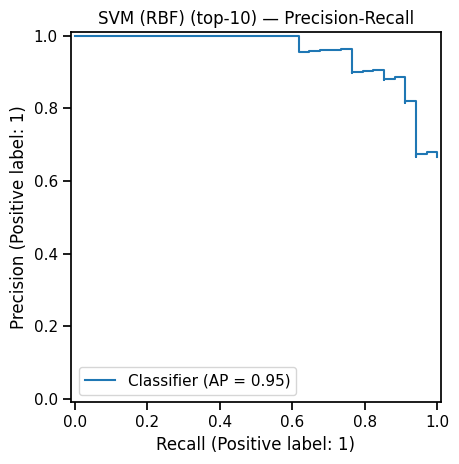

XGBoost — Acc: 0.882  F1(macro): 0.871  AUROC: 0.950  AUPRC: 0.977

XGBoost (top-10) — classification report
              precision    recall  f1-score   support

          CN      0.789     0.882     0.833        17
          AD      0.938     0.882     0.909        34

    accuracy                          0.882        51
   macro avg      0.863     0.882     0.871        51
weighted avg      0.888     0.882     0.884        51



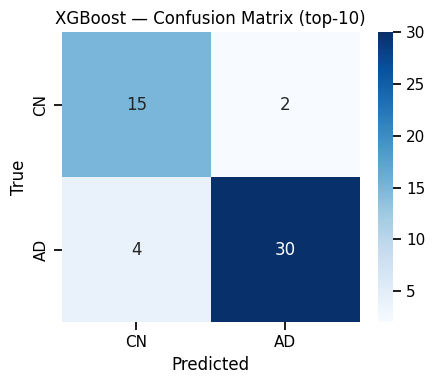

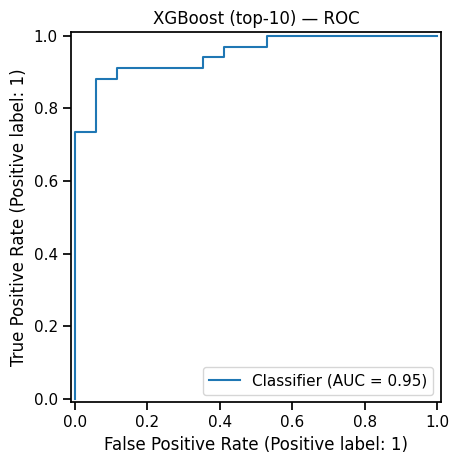

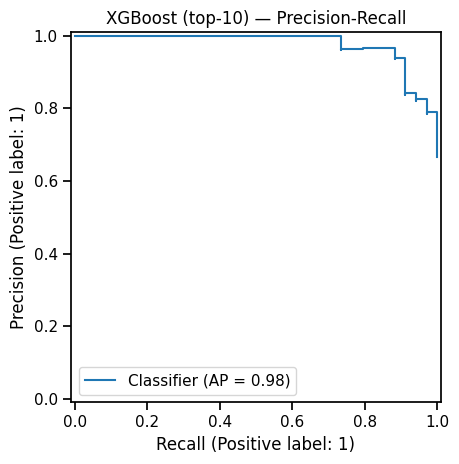

,,acc,f1_macro,auroc,auprc,y_pred
SVM (RBF),4,0.784314,0.771673,0.870242,0.945307,"[1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, ..."
XGBoost,4,0.843137,0.828283,0.875433,0.931332,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
SVM (RBF),6,0.901961,0.888011,0.923875,0.965552,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
XGBoost,6,0.843137,0.828283,0.897924,0.947839,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
SVM (RBF),8,0.862745,0.837801,0.896194,0.951893,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
XGBoost,8,0.882353,0.871212,0.920415,0.952146,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
SVM (RBF),10,0.823529,0.791458,0.894464,0.954438,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."
XGBoost,10,0.882353,0.871212,0.949827,0.977187,"[1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, ..."


In [19]:
# Numbers of features
top_k_list = [4, 6, 8, 10]

# Dictionary for results
retrain_results = {}

for k in top_k_list:
    print(f"\n=== Retraining with Top-{k} Features ===")
    
    # Get top-k feature names for each model
    svm_features = top_svm.index[:k]
    xgb_features = top_xgb.index[:k]

    # Train svm
    X_train_svm = X_train_raw[svm_features]
    X_test_svm  = X_test_raw[svm_features]

    svm_pipe.fit(X_train_svm, y_train)
    proba = svm_pipe.predict_proba(X_test_svm)
    y_proba = proba[:, 1] if is_binary else proba
    scores = compute_scores(y_test, y_proba)
    retrain_results[(f"SVM (RBF)", k)] = scores

    print(f"SVM (RBF) — Acc: {scores['acc']:.3f}  F1(macro): {scores['f1_macro']:.3f}  "
          f"AUROC: {scores['auroc']:.3f}  AUPRC: {scores['auprc']:.3f}")
    report(y_test, scores["y_pred"], name=f"SVM (RBF) (top-{k})")
    show_confusion_matrix(y_test, scores["y_pred"], title=f"SVM (RBF) — Confusion Matrix (top-{k})")
    plot_roc_pr(y_test, y_proba, name=f"SVM (RBF) (top-{k})")

    # train xgboost
    X_train_xgb = X_train_raw[xgb_features]
    X_test_xgb  = X_test_raw[xgb_features]

    xgb_pipe.fit(X_train_xgb, y_train)
    proba = xgb_pipe.predict_proba(X_test_xgb)
    y_proba = proba[:, 1] if is_binary else proba
    scores = compute_scores(y_test, y_proba)
    retrain_results[(f"XGBoost", k)] = scores

    print(f"XGBoost — Acc: {scores['acc']:.3f}  F1(macro): {scores['f1_macro']:.3f}  "
          f"AUROC: {scores['auroc']:.3f}  AUPRC: {scores['auprc']:.3f}")
    report(y_test, scores["y_pred"], name=f"XGBoost (top-{k})")
    show_confusion_matrix(y_test, scores["y_pred"], title=f"XGBoost — Confusion Matrix (top-{k})")
    plot_roc_pr(y_test, y_proba, name=f"XGBoost (top-{k})")

# Output viewing
results_df = pd.DataFrame(retrain_results).T
results_df


## Neural network

Fold 1/5 — Acc: 0.833  F1(macro): 0.829  AUROC: 0.837  AUPRC: 0.900
Fold 2/5 — Acc: 0.875  F1(macro): 0.855  AUROC: 0.797  AUPRC: 0.867
Fold 3/5 — Acc: 0.875  F1(macro): 0.869  AUROC: 0.945  AUPRC: 0.977
Fold 4/5 — Acc: 0.958  F1(macro): 0.952  AUROC: 0.992  AUPRC: 0.996
Fold 5/5 — Acc: 0.783  F1(macro): 0.732  AUROC: 0.867  AUPRC: 0.929

==== Cross-Validation (5-fold) ====
Acc:   0.865 ± 0.065
F1(ma):0.847 ± 0.079
AUROC: 0.888 ± 0.080
AUPRC: 0.934 ± 0.053

OOF — Acc: 0.866  F1(macro): 0.851  AUROC: 0.892  AUPRC: 0.939
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - AUPRC: 0.7675 - AUROC: 0.6160 - accuracy: 0.5618 - loss: 1.3919 - val_AUPRC: 0.8240 - val_AUROC: 0.6772 - val_accuracy: 0.6333 - val_loss: 1.3326 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - AUPRC: 0.8008 - AUROC: 0.7031 - accuracy: 0.6292 - loss: 1.2973 - val_AUPRC: 0.8360 - val_AUROC: 0.7116 - val_accuracy: 0.6667 - val_loss: 1.2915 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━

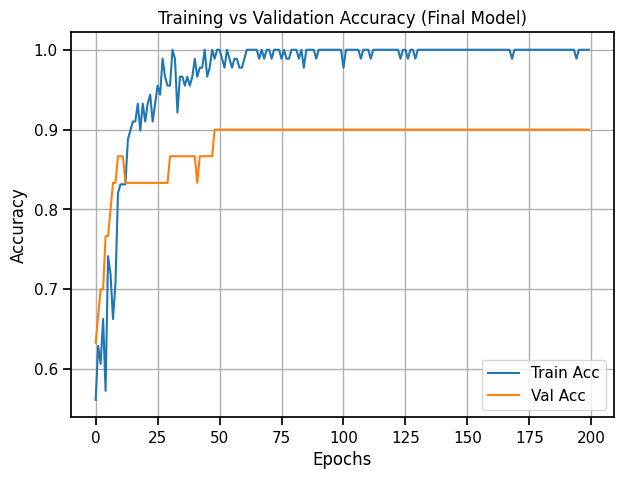


NeuralNet (Final) — Acc: 0.824  F1(macro): 0.804  AUROC: 0.825  AUPRC: 0.820

NeuralNet (Final) — classification report
              precision    recall  f1-score   support

          CN      0.722     0.765     0.743        17
          AD      0.879     0.853     0.866        34

    accuracy                          0.824        51
   macro avg      0.801     0.809     0.804        51
weighted avg      0.827     0.824     0.825        51



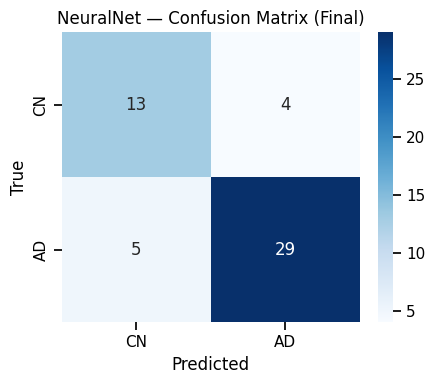

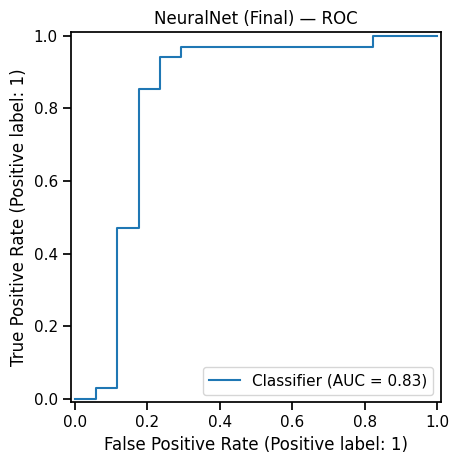

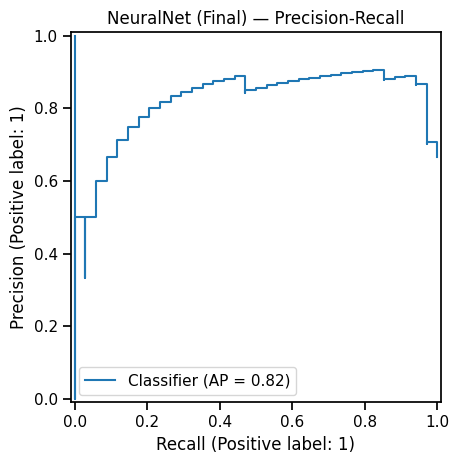

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt

np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# ----- Model factory -----
def create_model(n_features, out_units, out_act, l2_reg=4e-3, lr=1e-3):
    model = Sequential([
        Dense(96, activation="relu", kernel_regularizer=regularizers.l2(l2_reg),
              input_shape=(n_features,)),
        Dropout(0.4),
        Dense(32, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)),
        Dropout(0.3),
        Dense(out_units, activation=out_act)
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy" if out_units == 1 else "sparse_categorical_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.AUC(name="AUROC", curve="ROC"),
            tf.keras.metrics.AUC(name="AUPRC", curve="PR"),
        ]
    )
    return model

# Define output units and output activation function
n_features = X_train_raw.shape[1]
out_units = 1 if is_binary else len(class_order)
out_act   = "sigmoid" if is_binary else "softmax"

# Training with cross validation
K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=RANDOM_STATE)

cv_metrics = {"acc": [], "f1_macro": [], "auroc": [], "auprc": []}
oof_proba = np.zeros((len(y_train), out_units if not is_binary else 1), dtype=float)

fold_idx = 1
for tr_idx, val_idx in skf.split(X_train_raw, y_train):
    X_tr_raw, X_val_raw = X_train_raw.iloc[tr_idx], X_train_raw.iloc[val_idx]
    y_tr,     y_val     = y_train.iloc[tr_idx],  y_train.iloc[val_idx]

    # Fit imputer/scaler on training fold only
    imputer = SimpleImputer(strategy="median")
    scaler  = StandardScaler()

    X_tr_imp  = imputer.fit_transform(X_tr_raw)
    X_val_imp = imputer.transform(X_val_raw)

    X_tr = scaler.fit_transform(X_tr_imp)
    X_val = scaler.transform(X_val_imp)

    # Class weights per fold
    classes = np.unique(y_tr)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
    class_weights = {int(c): float(w) for c, w in zip(classes, weights)}

    # Callbacks
    early = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, verbose=0)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=0)

    # Model
    model = create_model(n_features, out_units, out_act, l2_reg=4e-3, lr=1e-3)

    # Train (pass the validation fold for early stopping monitoring)
    model.fit(
        X_tr, y_tr.values,
        validation_data=(X_val, y_val.values),
        epochs=200, batch_size=64,
        callbacks=[early, reduce_lr],
        class_weight=class_weights,
        verbose=0
    )

    # Predict on validation fold to get OOF preds
    if is_binary:
        y_val_proba = model.predict(X_val, verbose=0).ravel()
        oof_proba[val_idx, 0] = y_val_proba
    else:
        y_val_proba = model.predict(X_val, verbose=0)
        oof_proba[val_idx, :] = y_val_proba

    # Fold metrics
    fold_scores = compute_scores(y_val.values, y_val_proba)
    cv_metrics["acc"].append(fold_scores["acc"])
    cv_metrics["f1_macro"].append(fold_scores["f1_macro"])
    cv_metrics["auroc"].append(fold_scores["auroc"])
    cv_metrics["auprc"].append(fold_scores["auprc"])

    print(f"Fold {fold_idx}/{K} — "
          f"Acc: {fold_scores['acc']:.3f}  F1(macro): {fold_scores['f1_macro']:.3f}  "
          f"AUROC: {fold_scores['auroc']:.3f}  AUPRC: {fold_scores['auprc']:.3f}")
    fold_idx += 1

# summary
def mean_std(x): 
    return np.mean(x), np.std(x, ddof=1) if len(x) > 1 else (float(x[0]), 0.0)

m_acc, s_acc = mean_std(cv_metrics["acc"])
m_f1,  s_f1  = mean_std(cv_metrics["f1_macro"])
m_roc, s_roc = mean_std(cv_metrics["auroc"])
m_pr,  s_pr  = mean_std(cv_metrics["auprc"])

print("\n==== Cross-Validation ({}-fold) ====".format(K))
print(f"Acc:   {m_acc:.3f} ± {s_acc:.3f}")
print(f"F1(ma):{m_f1:.3f} ± {s_f1:.3f}")
print(f"AUROC: {m_roc:.3f} ± {s_roc:.3f}")
print(f"AUPRC: {m_pr:.3f} ± {s_pr:.3f}")

# OOF diagnostics
oof_scores = compute_scores(y_train.values, oof_proba if not is_binary else oof_proba.ravel())
print(f"\nOOF — Acc: {oof_scores['acc']:.3f}  F1(macro): {oof_scores['f1_macro']:.3f}  "
      f"AUROC: {oof_scores['auroc']:.3f}  AUPRC: {oof_scores['auprc']:.3f}")

# fit on full training set

# Train-only preprocessing on FULL train (for final model)
imputer_nn = SimpleImputer(strategy="median")
scaler_nn  = StandardScaler()

X_train_imp = imputer_nn.fit_transform(X_train_raw)
X_test_imp  = imputer_nn.transform(X_test_raw)

X_train_nn = scaler_nn.fit_transform(X_train_imp)
X_test_nn  = scaler_nn.transform(X_test_imp)

# Final model
model_nn = create_model(n_features, out_units, out_act, l2_reg=4e-3, lr=1e-3)

# Class weights on full training set
classes_full = np.unique(y_train)
weights_full = compute_class_weight(class_weight="balanced", classes=classes_full, y=y_train)
class_weights_full = {int(c): float(w) for c, w in zip(classes_full, weights_full)}

early = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-6, verbose=1)

history = model_nn.fit(
    X_train_nn, y_train.values,
    validation_split=0.25,       # internal validation for early stopping on full training
    epochs=200, batch_size=64,
    callbacks=[early, reduce_lr],
    class_weight=class_weights_full,
    verbose=1
)

# Training curves
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Final Model)')
plt.legend()
plt.grid(True)
plt.show()

# Predict and evaluate on test set
if is_binary:
    y_proba_nn = model_nn.predict(X_test_nn, verbose=0).ravel()
else:
    y_proba_nn = model_nn.predict(X_test_nn, verbose=0)

scores_nn = compute_scores(y_test.values, y_proba_nn)
print(f"\nNeuralNet (Final) — Acc: {scores_nn['acc']:.3f}  F1(macro): {scores_nn['f1_macro']:.3f}  "
      f"AUROC: {scores_nn['auroc']:.3f}  AUPRC: {scores_nn['auprc']:.3f}")

report(y_test, scores_nn['y_pred'], name="NeuralNet (Final)")
show_confusion_matrix(y_test, scores_nn['y_pred'], title="NeuralNet — Confusion Matrix (Final)")
plot_roc_pr(y_test.values, y_proba_nn, name="NeuralNet (Final)")


## Summary of models

In [21]:
# Add original models
summary = {
    "SVM (RBF) (all features)": {m: v for m, v in results["SVM (RBF)"].items() if m != "y_pred"},
    "XGBoost (all features)":   {m: v for m, v in results["XGBoost"].items() if m != "y_pred"},
    "NeuralNet (all features)": {m: v for m, v in scores_nn.items() if m != "y_pred"},
}

# Add models with k features
for (model_name, k), metrics in retrain_results.items():
    summary[f"{model_name} (top-{k})"] = {m: v for m, v in metrics.items() if m != "y_pred"}


summary_df = pd.DataFrame(summary).T
summary_df = summary_df.sort_values(by="auroc", ascending=False) # Sort by AUROC

summary_df



,acc,f1_macro,auroc,auprc
XGBoost (top-10),0.882353,0.871212,0.949827,0.977187
SVM (RBF) (all features),0.882353,0.863393,0.925606,0.957779
SVM (RBF) (top-6),0.901961,0.888011,0.923875,0.965552
XGBoost (top-8),0.882353,0.871212,0.920415,0.952146
XGBoost (all features),0.882353,0.867647,0.920415,0.959057
XGBoost (top-6),0.843137,0.828283,0.897924,0.947839
SVM (RBF) (top-8),0.862745,0.837801,0.896194,0.951893
SVM (RBF) (top-10),0.823529,0.791458,0.894464,0.954438
XGBoost (top-4),0.843137,0.828283,0.875433,0.931332
SVM (RBF) (top-4),0.784314,0.771673,0.870242,0.945307


## Relevant Plots

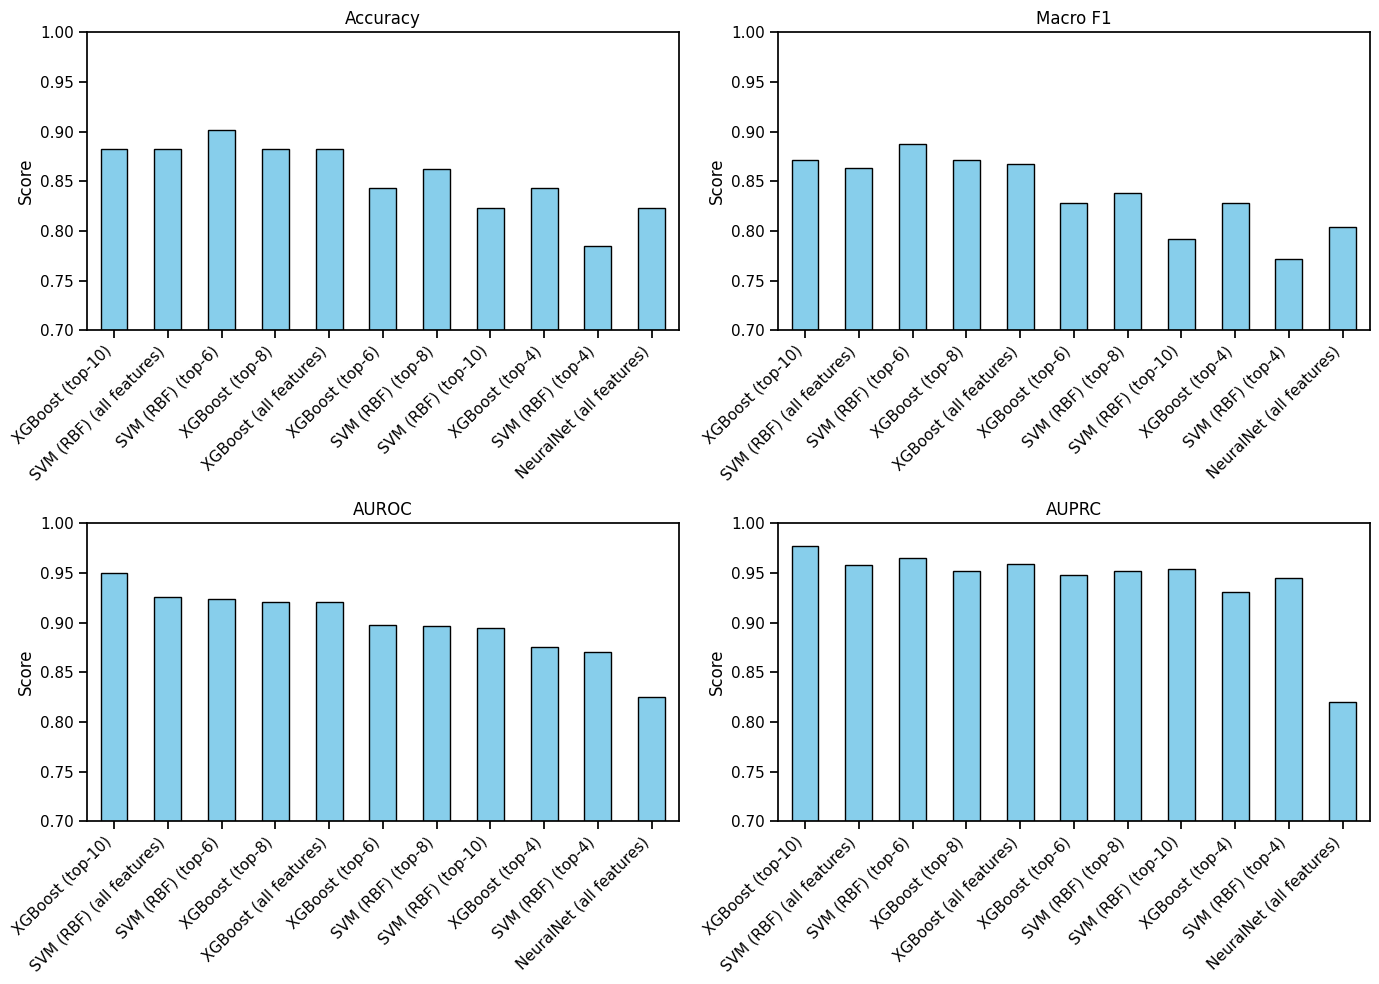

In [22]:
import matplotlib.pyplot as plt

metrics = ["acc", "f1_macro", "auroc", "auprc"]
titles = ["Accuracy", "Macro F1", "AUROC", "AUPRC"]

plt.figure(figsize=(14, 10))
for i, (metric, title) in enumerate(zip(metrics, titles), 1):
    plt.subplot(2, 2, i)
    summary_df[metric].plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(title)
    plt.ylabel("Score")
    plt.ylim(0.7, 1.0)
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()



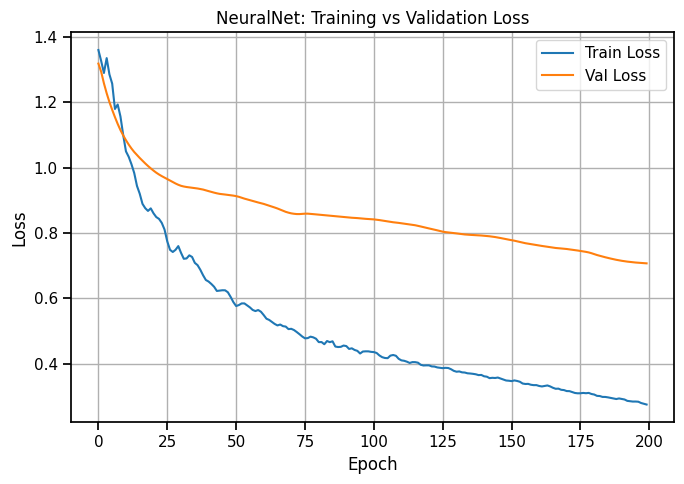

In [23]:
import numpy as np
import matplotlib.pyplot as plt


def moving_avg(x, k=3):
    if k <= 1: 
        return np.array(x, dtype=float)
    x = np.array(x, dtype=float)
    pad = k // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    return np.convolve(xpad, np.ones(k)/k, mode="valid")[:len(x)]


plt.figure(figsize=(7,5))
plt.plot(moving_avg(history.history["loss"], 3), label="Train Loss")
plt.plot(moving_avg(history.history["val_loss"], 3), label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("NeuralNet: Training vs Validation Loss")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

